In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import STL
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import seaborn as sns

! pip install adtk -q
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, QuantileAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, VolatilityShiftAD, CustomizedDetectorHD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 663.2 kB/s eta 0:00:00


Здесь д.б. сбор данных https://colab.research.google.com/drive/14pezbWyUPM2MLbeq257oVHfKOR6it3gi#scrollTo=Z-Ig7Bh9sVty

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/arinaaandreeva/Bachelors-thesis/main/data/all_curs.csv')
df = df[df['date'] >= '2015-01-01']

In [ ]:
df['full_date'] = pd.to_datetime(df['date'] + ' ' + df['time'])
 # Объединяем дату в общий столбец, сортируем по ней, ставим в индекс и удаляем ненужное
df = df.rename(columns={'USDRUS_TOM_close': 'USD', 'CNYRUS_TOM_close' :'CNY', 'EURRUS_TOM_close' : 'EUR'}) \
    .set_index('full_date') \
    .drop(columns = ['Unnamed: 0', 'date', 'time']) \
    .sort_index()


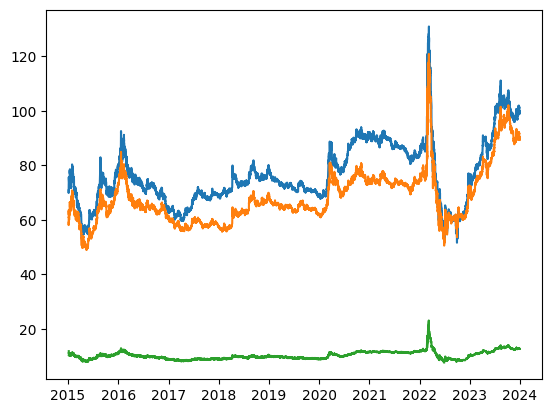

In [ ]:
plt.plot(df[['EUR', 'USD']])
plt.plot(df['CNY'])

In [ ]:
 # Делим данные на тестовую и тренирововчную. Так как у нас временной ряд делим на отрезки по времени (не перемешиваем)
train_df = df.head(int(.75 *len(df)))
test_df = df.tail(int(.25 *len(df)))

In [ ]:
print(train_df.shape)
print(test_df.shape)

(23498, 3)
(7832, 3)


In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train_df)
train_df = pd.DataFrame(scaler.transform(train_df), columns=df.columns)
test_df = pd.DataFrame(scaler.transform(test_df), columns=df.columns)

In [ ]:
df_return = (df - df.shift(1))/df.shift(1)
df_return.dropna(inplace=True)

## Min max quantile

Threshold Anomaly Detection (manually define min max threshold)

In [ ]:
s = validate_series(df_return['USD'])

Quantile Anomaly Detection (manually define percentiles)

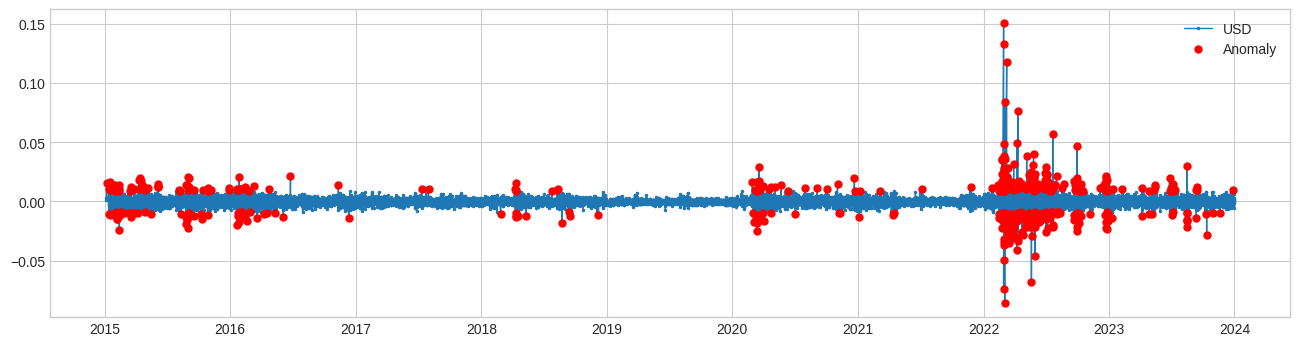

In [ ]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.show()

 Inter Quartile Range Anomaly Detection (IQR = Q3 - Q1, with c we multiply for tolerance, so c * IQR)

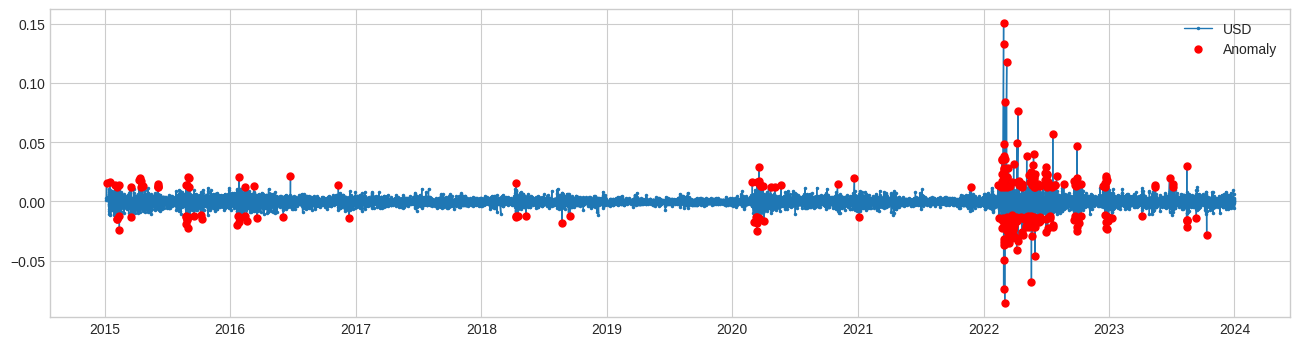

In [ ]:

iqr_ad = InterQuartileRangeAD(c=5)
anomalies = iqr_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.show()

### STL LOESS

In [ ]:
df_loess = df['USD'].dropna()
df_loess = df_loess.resample('H').mean().ffill()
df_loess = df_loess.asfreq(pd.infer_freq(df_loess.index))

stl = STL(df_loess)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

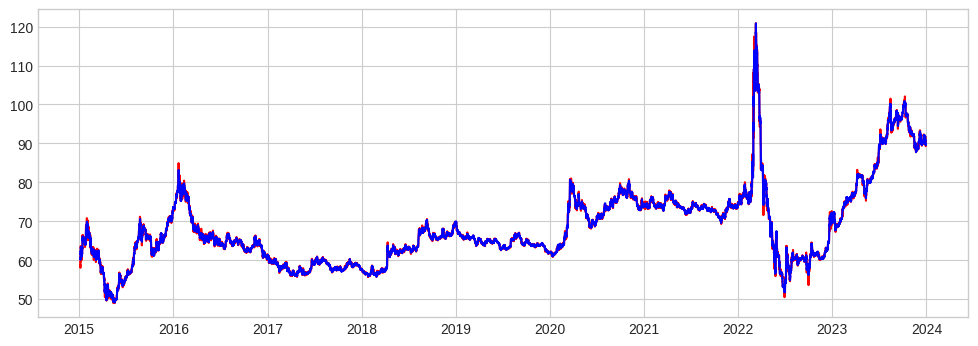

In [ ]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_loess, c ='r')
plt.plot(estimated, c = 'b')

In [ ]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
anomalies = df_loess[(resid < lower) | (resid > upper)]
anomalies

full_date
2015-01-05 10:00:00    58.9480
2015-01-05 11:00:00    58.0500
2015-01-05 12:00:00    58.2625
2015-01-05 13:00:00    58.6640
2015-01-05 14:00:00    58.5000
                        ...   
2023-10-27 14:00:00    92.7550
2023-10-31 10:00:00    92.1100
2023-10-31 11:00:00    91.7525
2023-10-31 12:00:00    91.8675
2023-12-29 18:00:00    90.3600
Name: USD, Length: 1073, dtype: float64

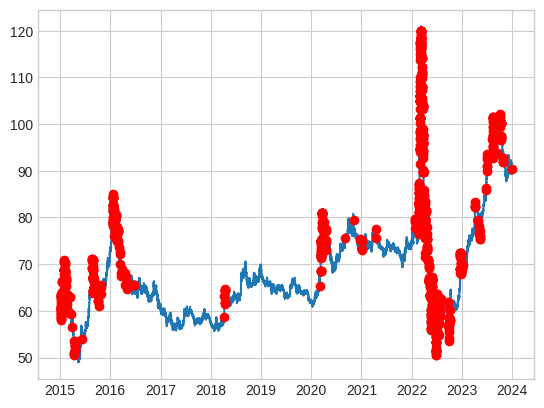

In [ ]:
plt.plot(df_loess)
plt.plot(anomalies, 'ro')

 STL + IQR хороший способ для данных, в которых мало сезонности

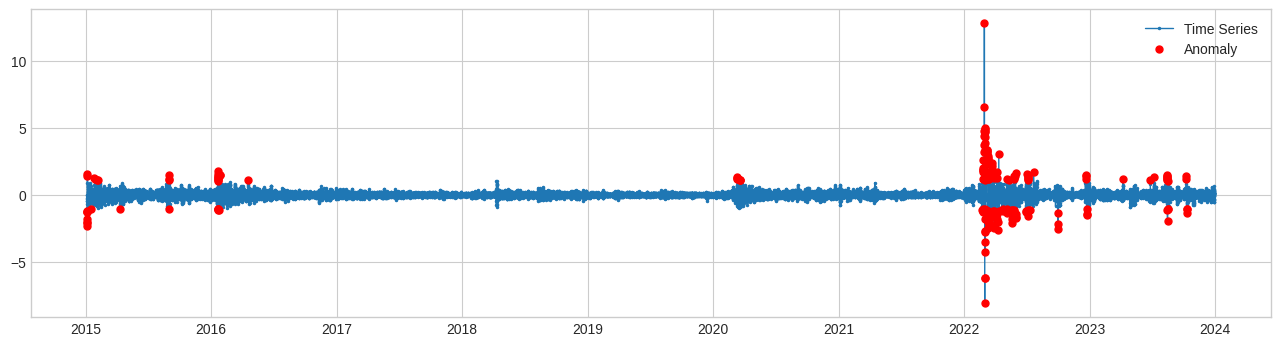

In [ ]:
DETREND = df['USD'] - estimated
iqr_ad = InterQuartileRangeAD(c=5.5)
anomalies = iqr_ad.fit_detect(DETREND)
plot(DETREND, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.show()

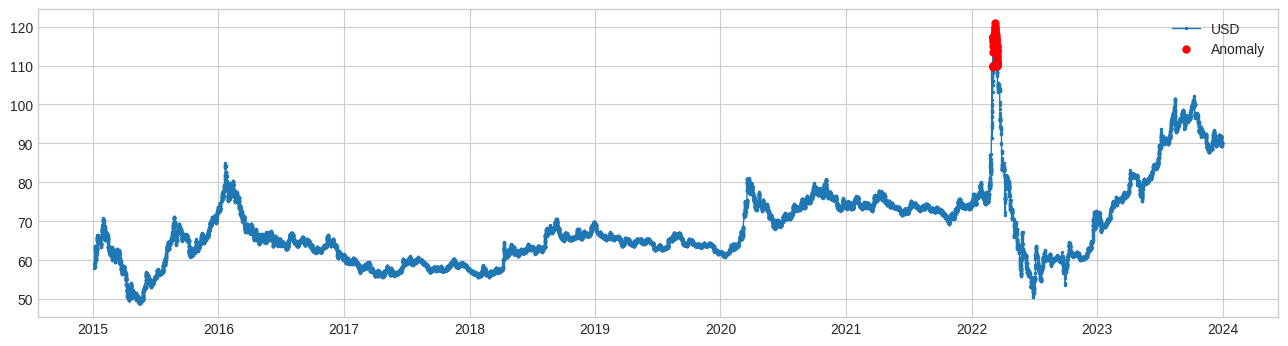

In [ ]:
esd_ad = GeneralizedESDTestAD(alpha=0.3)
anomalies = esd_ad.fit_detect(s)
plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

## Distribution-based models + density-based models




### Baseline: median absolute deviation (MAD)

In [ ]:
df_new = df_return.copy()
df_new['USD_1'] = df['USD']

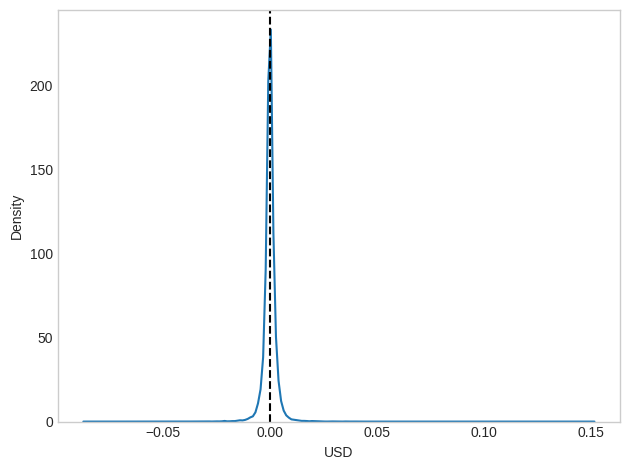

In [ ]:
sns.kdeplot(df_return['USD']);
plt.grid(False)
plt.axvline(np.median(df_return['USD']), 0, 1, c='black', ls='--')
plt.tight_layout()

In [ ]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df_return['USD'])
median = np.median(df_return['USD'])

print(median)
print(mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.0
0.0010732904017171602


In [ ]:

df_new['z-score_return'] = df_return['USD'].apply(compute_robust_z_score)

mad = median_abs_deviation(df['USD'])
median = np.median(df['USD'])
df_new['z-score'] = df['USD'].apply(compute_robust_z_score)
df_new.head()

,USD,EUR,CNY,USD_1,z-score_return,z-score
full_date,,,,,,
2015-01-05 16:00:00,0.001281,0.001772,-0.001521,59.4095,0.804967,-0.670605
2015-01-05 17:00:00,0.002710,0.002272,0.001468,59.5705,1.703079,-0.653657
2015-01-06 11:00:00,0.015618,0.010135,0.000000,62.4600,9.815004,-0.349487
2015-01-06 15:00:00,0.001717,-0.007007,0.002717,62.7000,1.079322,-0.324223
2015-01-06 16:00:00,0.003509,0.006391,0.000000,62.9200,2.205057,-0.301064


In [ ]:
df_new['baseline'] = 1

df_new.loc[df_new['z-score'] >= 3.5, 'baseline'] = -1
df_new.loc[df_new['z-score'] <=-3.5, 'baseline'] = -1

df_new['baseline_return'] = 1

df_new.loc[df_new['z-score_return'] >= 3.5, 'baseline_return'] = -1
df_new.loc[df_new['z-score_return'] <=-3.5, 'baseline_return'] = -1

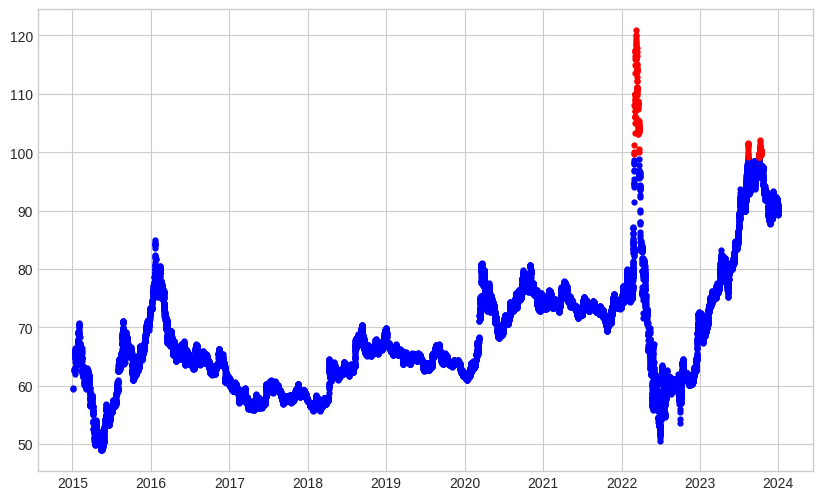

In [ ]:
ones = df_new[df_new['baseline'] == -1]
zeros = df_new[df_new['baseline'] == 1]

plt.figure(figsize=(10, 6))
plt.plot(zeros['USD_1'], 'bo', label='Обычные', markersize=3.5)  # Синие точки для нулей
plt.plot(ones['USD_1'], 'ro', label='Аномальные', markersize=3.5)  # Красные точки для единиц

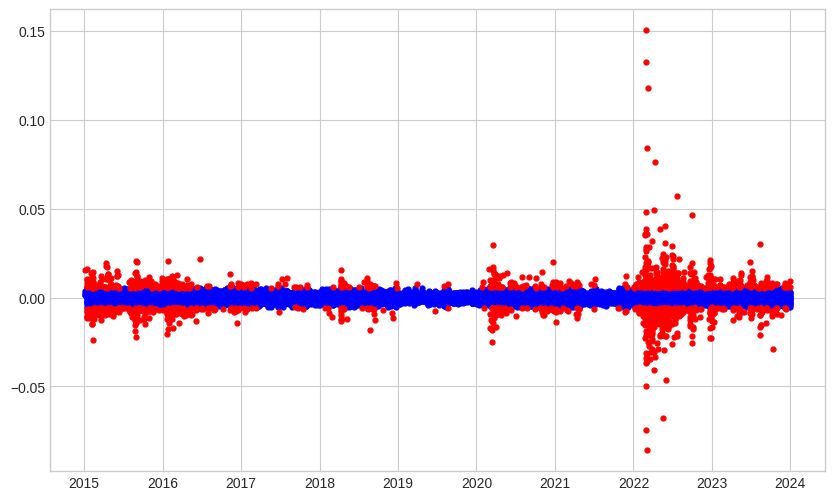

In [ ]:
ones = df_new[df_new['baseline_return'] == -1]
zeros = df_new[df_new['baseline_return'] == 1]

plt.figure(figsize=(10, 6))
plt.plot(zeros['USD'], 'bo', label='Обычные', markersize=3.5)  # Синие точки для нулей
plt.plot(ones['USD'], 'ro', label='Аномальные', markersize=3.5)  # Красные точки для единиц

### Copula-Based Outlier Detection — COPOD

Сейчас обучается на многомерных рядах, сделать отельно на одномерных

In [ ]:
! pip install pyod -q
import pyod
from pyod.models.copod import COPOD

! pip install pythresh -q
import pythresh
from pythresh.thresholds.filter import FILTER

In [ ]:
# Copula-Based Outlier Detection — COPOD
clf = COPOD()
clf.fit(train_df.dropna())

# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores
y_test_scores = clf.decision_function(test_df)  # outlier scores

COPOD is an unsupervised outlier detection algorithm that works by first building a model of the normal behavior of the data and then identifying instances that deviate significantly from this model as outliers.
   - It uses **a combination of distance-based and density-based methods** to detect outliers in the data.
   - During the training phase (clf.fit(train_df)), COPOD learns the characteristics of the normal data and assigns outlier scores to each instance in the training dataset.
   - The outlier scores represent how much each instance deviates from the learned normal behavior.

In [ ]:
thres = FILTER()
labels = thres.eval(y_test_scores) # значения переводим в 0 и 1

In [ ]:
labels_df = pd.DataFrame(labels, columns =['label'])
df_new2 = test_df.copy()
df_new2['copod'] = labels

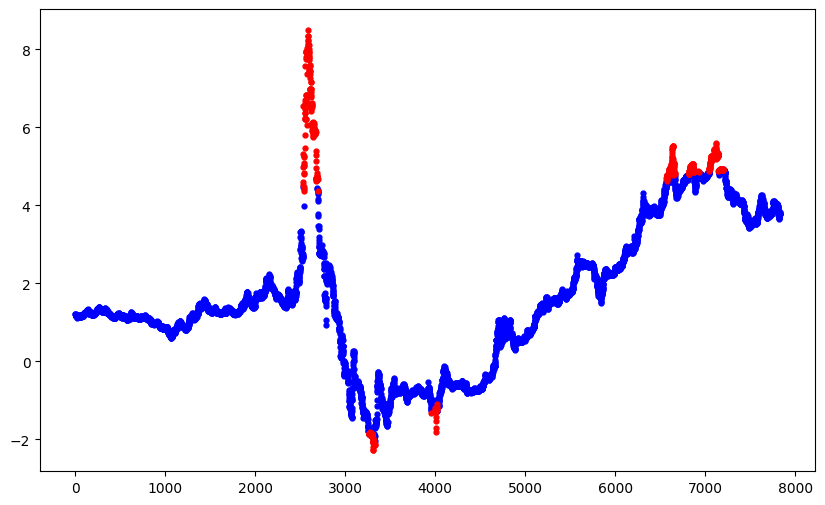

In [ ]:
ones = df_new2[df_new2['copod'] == 1]
zeros = df_new2[df_new2['copod'] == 0]

# Строим график
plt.figure(figsize=(10, 6))
#plt.plot(zeros[['USD', 'EUR', 'CNY']], 'bo', label='Обычные')  # Синие точки для нулей
#plt.plot(ones[['USD', 'EUR', 'CNY']], 'ro', label='Аномальные')  # Красные точки для единиц
plt.plot(zeros['USD'], 'bo', label='Обычные', markersize=3.5)  # Синие точки для нулей
plt.plot(ones['USD'], 'ro', label='Аномальные', markersize=3.5)  # Красные точки для единиц

### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
model=IsolationForest(n_estimators=1000, max_samples='auto', contamination = 0.1,max_features = 1.0)
model.fit(train_df[['USD']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, n_estimators=1000)

In [ ]:
df_new2['scores']=model.decision_function(test_df[['USD']])
df_new2['IsFor']=model.predict(test_df[['USD']])

In [ ]:
df_new2['IsFor'].value_counts()

 1    4504
-1    3328
Name: IsFor, dtype: int64

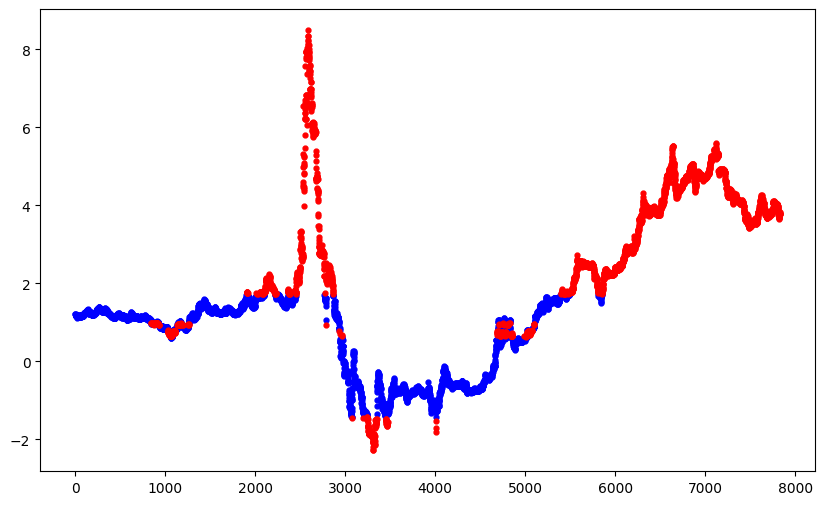

In [ ]:
ones = df_new2[df_new2['IsFor'] == -1]
zeros = df_new2[df_new2['IsFor'] == 1]

plt.figure(figsize=(10, 6))
plt.plot(zeros['USD'], 'bo', label='Обычные', markersize=3.5)  # Синие точки для нулей
plt.plot(ones['USD'], 'ro', label='Аномальные', markersize=3.5)  # Красные точки для единиц

In [ ]:
#val_df = df.head(int(.4 *len(df)))
#test_df = df.tail(int(.6 *len(df)))
#print(test_df.shape)
#print(val_df.shape)

### Local outlier factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=3, contamination = 0.15, novelty = True)
train_lof = train_df['USD'].values.reshape(-1, 1)
lof.fit(train_lof)

In [ ]:
preds_lof = lof.predict(test_df['USD'].values.reshape(-1,1))

In [ ]:
df_new2['LOF'] = preds_lof
df_new2['LOF'].value_counts()

In [ ]:
ones = df_new2[df_new2['LOF'] == -1]
zeros = df_new2[df_new2['LOF'] == 1]

plt.figure(figsize=(10, 6))
plt.plot(ones['USD'], 'ro', label='Аномальные', markersize=3.5)  # Красные точки для единиц
plt.plot(zeros['USD'], 'bo', label='Обычные', markersize=3.5)  # Синие точки для нулей

In [ ]:
# MinPts
M = [5, 10, 50]
# Percentile to choose eps
P = [5, 10, 30, 50, 70, 90, 95]

X = df['USD']
X_mean = X.mean()
X_std = X.std()
X_norm = (X - X_mean) / X_std
X_norm = X_norm.to_numpy() # convert to numpy array

## Find distances for set M
MinPts_eps = {} # hyperparameters (minpts, eps) candidates for each component in ensemble
model_count = 0 # number of components in ensemble
# generate hyperparameter pairs (minpts, eps)
for m in M:
    D_q = []
    # find average distance d_i from point i to its immediate neighbors in the window
    # (the neighbor MinPts on one side and MinPts on the other side along the time axis)
    for i in range(m, len(X_norm) - m, 1):
        d_i = np.mean(abs(X_norm[i-m:i+m+1]-X_norm[i]))
        D_q.append(d_i)
    # 3.2. Find eps as P percentiles of D_q
    for percentile in P:
        eps = np.percentile(D_q, percentile)
        if eps > 0:
            model_count += 1
            if m not in MinPts_eps.keys():
                MinPts_eps[m] = [eps]
            else:
                MinPts_eps[m].append(eps)


## Clustering

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
  eps = 0.5,
  metric="euclidean",
  min_samples = 4,
  n_jobs = -1)

dbscan_model = dbscan.fit(train_df[['USD', 'EUR', 'CNY']].dropna())


In [ ]:
dbscan_pred = dbscan.fit_predict(test_df.dropna())

In [ ]:
set(dbscan_pred)

{-1, 0, 1, 2, 3, 4, 5, 6}

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(df)
print(kmeans.labels_)

lbl, cnt = np.unique(kmeans.labels_,return_counts=True)
print(lbl)
print(cnt)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 ... 0 0 0]
[0 1]
[ 5977 12753]


Since the difference in the number of labels of 0 and 1 is not large, it is difficult to judge either of them as outliers, so the number of groups should be increased and analyzed.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(df)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['group:0-count:2137',
 'group:1-count:2189',
 'group:2-count:769',
 'group:3-count:843',
 'group:4-count:1428',
 'group:5-count:589',
 'group:6-count:356',
 'group:7-count:324',
 'group:8-count:1345',
 'group:9-count:424',
 'group:10-count:1901',
 'group:11-count:600',
 'group:12-count:565',
 'group:13-count:850',
 'group:14-count:731',
 'group:15-count:2074',
 'group:16-count:449',
 'group:17-count:244',
 'group:18-count:495',
 'group:19-count:417']

In [ ]:
df_kmeans = df[(kmeans.labels_== 3)|(kmeans.labels_== 12)
 |(kmeans.labels_== 16) |(kmeans.labels_== 17)]

In [ ]:
plt.plot(df['USD'])
plt.plot(df_kmeans['USD'], 'ro', markersize=3.5)

Groups 3, 12,16 which are particularly smaller than other groups, can be classified as singular groups and judged as outliers.

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.7, min_samples=2).fit(df)
print(clustering)  # BSCAN(eps=0.7, min_samples=2)
print(clustering.labels_)  # [0 0 0 ... 0 0 0]

lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

all clasters except the 2nd are anomalies

In [ ]:
df_dbscan = df[(clustering.labels_!= 2)]

In [ ]:
plt.plot(df['USD'])
plt.plot(df_dbscan['USD'], 'ro', markersize=3.5)

## OCSVM

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
svm.fit(train_df['USD'].values.reshape(-1, 1))

OneClassSVM(gamma='auto', nu=0.1)

In [ ]:
pred = svm.predict(test_df['USD'].values.reshape(-1, 1))

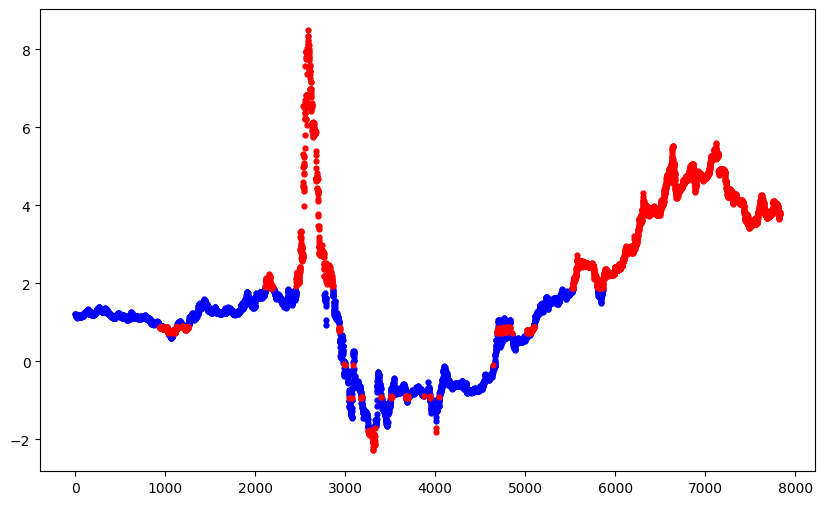

In [ ]:
df_new2['svm'] = pred
ones = df_new2[df_new2['svm'] == -1]
zeros = df_new2[df_new2['svm'] == 1]

plt.figure(figsize=(10, 6))

plt.plot(zeros['USD'], 'bo', label='Обычные', markersize=3.5)  # Синие точки для нулей
plt.plot(ones['USD'], 'ro', label='Аномальные', markersize=3.5)  # Красные точки для единиц

In [ ]:
scores = svm.score_samples(test_df['USD'].values.reshape(-1, 1))
thresh = np.quantile(scores, 0.05)
thresh

0.5065597143418756

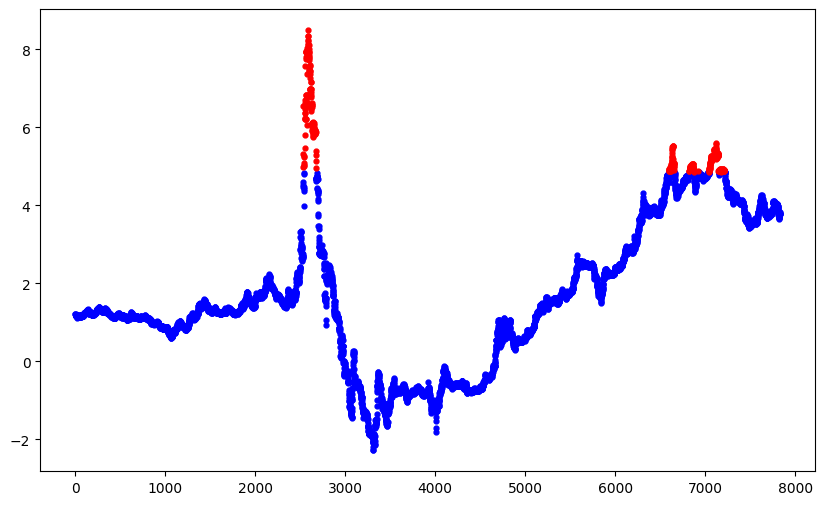

In [ ]:
df_new2['svm_score'] = scores
ones = df_new2[df_new2['svm_score'] <= thresh]
zeros = df_new2[df_new2['svm_score'] > thresh]

plt.figure(figsize=(10, 6))

plt.plot(zeros['USD'], 'bo', label='Обычные', markersize=3.5)
plt.plot(ones['USD'], 'ro', label='Аномальные', markersize=3.5)

## LSTM AE

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [ ]:
seq_size = 24*7  # Number of time steps to look back - week

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])

    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train_df[['USD']], train_df['USD'], seq_size)
testX, testY = to_sequences(test_df[['USD']], test_df['USD'], seq_size)

In [ ]:
model = Sequential()
model.add(LSTM(
    units=64,
    input_shape=(trainX.shape[1], trainX.shape[2])
))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=trainX.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(
  TimeDistributed(Dense(units=trainX.shape[2]))
)
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    trainX, trainY,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
657/657 [==============================] - 116s 171ms/step - loss: 0.1280 - val_loss: 0.1109
Epoch 2/10
657/657 [==============================] - 111s 170ms/step - loss: 0.1360 - val_loss: 0.1778
Epoch 3/10
657/657 [==============================] - 109s 165ms/step - loss: 0.1347 - val_loss: 0.1594
Epoch 4/10
657/657 [==============================] - 109s 166ms/step - loss: 0.1295 - val_loss: 0.1670
Epoch 5/10
657/657 [==============================] - 110s 167ms/step - loss: 0.1280 - val_loss: 0.1750
Epoch 6/10
657/657 [==============================] - 108s 165ms/step - loss: 0.1306 - val_loss: 0.1809
Epoch 7/10
657/657 [==============================] - 109s 166ms/step - loss: 0.1299 - val_loss: 0.1857
Epoch 8/10
657/657 [==============================] - 110s 167ms/step - loss: 0.1299 - val_loss: 0.1773
Epoch 9/10
657/657 [==============================] - 110s 167ms/step - loss: 0.1150 - val_loss: 0.1744
Epoch 10/10
657/657 [==============================] - 110s 167m

In [ ]:
X_train_pred = model.predict(trainX)
train_mae_loss = np.mean(np.abs(X_train_pred - trainX), axis=1)

730/730 [==============================] - 57s 77ms/step


(array([1364., 3959., 3811., 3089., 2326., 1399., 1233.,  992.,  733.,
         663.,  489.,  524.,  438.,  394.,  437.,  287.,  346.,  187.,
         159.,  129.,  140.,   90.,   55.,   27.,   18.,   10.,   16.,
           5.,    6.,    4.]),
 array([0.01858067, 0.05353269, 0.0884847 , 0.12343672, 0.15838873,
        0.19334075, 0.22829276, 0.26324477, 0.29819679, 0.3331488 ,
        0.36810082, 0.40305283, 0.43800485, 0.47295686, 0.50790887,
        0.54286089, 0.5778129 , 0.61276492, 0.64771693, 0.68266895,
        0.71762096, 0.75257298, 0.78752499, 0.822477  , 0.85742902,
        0.89238103, 0.92733305, 0.96228506, 0.99723708, 1.03218909,
        1.0671411 ]),
 <BarContainer object of 30 artists>)

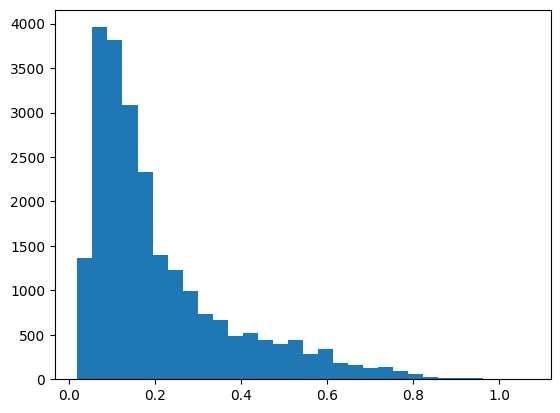

In [ ]:
plt.hist(train_mae_loss, bins=30)

In [ ]:
THRESHOLD = 0.9
X_test_pred = model.predict(testX)
test_mae_loss = np.mean(np.abs(X_test_pred - testX), axis=1)

240/240 [==============================] - 16s 68ms/step


In [ ]:
test_mae_loss

In [ ]:
test_score_df = pd.DataFrame(index=test_df[seq_size:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['USD'] = test_df[seq_size:].USD

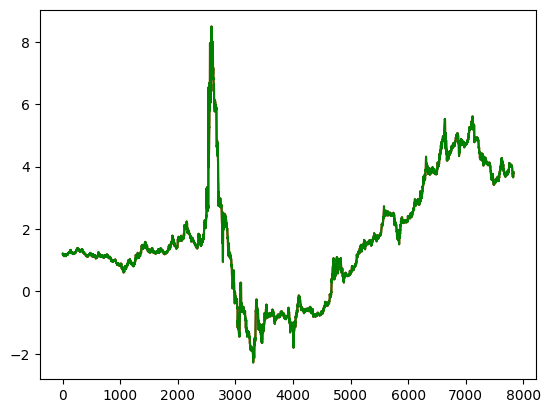

In [ ]:
plt.plot(test_score_df['USD'], 'r')
plt.plot(test_df['USD'], 'g')

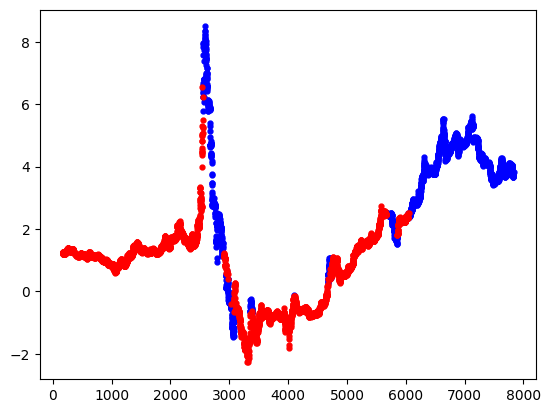

In [ ]:
true_points = test_score_df[test_score_df['anomaly'] == True]
false_points = test_score_df[test_score_df['anomaly'] == False]

plt.plot(false_points['USD'], 'bo', label='Normal', markersize=3.5)
plt.plot(true_points['USD'],  'ro', label='Anomaly', markersize=3.5)
plt.legend()

Вариант 2

In [ ]:
model = Sequential()
model.add(LSTM(
    units=64,
    input_shape=(trainX.shape[1], trainX.shape[2]),
    activation = 'tanh',
    recurrent_activation = 'sigmoid'
))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=trainX.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(
  TimeDistributed(Dense(units=trainX.shape[2]))
)
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    trainX, trainY,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.1,
    shuffle=False
)

Epoch 1/5
657/657 [==============================] - 123s 181ms/step - loss: 0.1190 - val_loss: 0.0811
Epoch 2/5
657/657 [==============================] - 116s 177ms/step - loss: 0.1157 - val_loss: 0.0877
Epoch 3/5
657/657 [==============================] - 116s 176ms/step - loss: 0.1223 - val_loss: 0.0839
Epoch 4/5
657/657 [==============================] - 122s 185ms/step - loss: 0.1198 - val_loss: 0.0808
Epoch 5/5
657/657 [==============================] - 116s 176ms/step - loss: 0.1048 - val_loss: 0.0751


In [ ]:
X_train_pred = model.predict(trainX)
train_mae_loss = np.mean(np.abs(X_train_pred - trainX), axis=1)

730/730 [==============================] - 42s 55ms/step


(array([1945., 3822., 3648., 2744., 2057., 1616., 1273., 1487., 1031.,
         999.,  766.,  437.,  229.,  140.,  163.,  135.,  117.,   73.,
          59.,   30.,   39.,   60.,   43.,  133.,   35.,   27.,   70.,
          26.,   53.,   73.]),
 array([0.01753672, 0.05984197, 0.10214723, 0.14445248, 0.18675774,
        0.22906299, 0.27136825, 0.3136735 , 0.35597876, 0.39828401,
        0.44058927, 0.48289452, 0.52519978, 0.56750503, 0.60981029,
        0.65211554, 0.6944208 , 0.73672605, 0.77903131, 0.82133656,
        0.86364182, 0.90594707, 0.94825233, 0.99055758, 1.03286284,
        1.07516809, 1.11747335, 1.15977861, 1.20208386, 1.24438912,
        1.28669437]),
 <BarContainer object of 30 artists>)

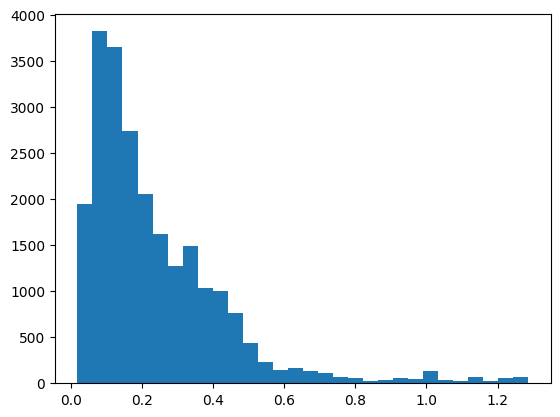

In [ ]:
plt.hist(train_mae_loss, bins=30)

In [ ]:
THRESHOLD = 1.2
X_test_pred = model.predict(testX)
test_mae_loss = np.mean(np.abs(X_test_pred - testX), axis=1)

240/240 [==============================] - 24s 99ms/step


In [ ]:
np.mean(test_mae_loss)

0.6464202083783832

In [ ]:
test_score_df = pd.DataFrame(index=test_df[seq_size:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['USD'] = test_df[seq_size:].USD

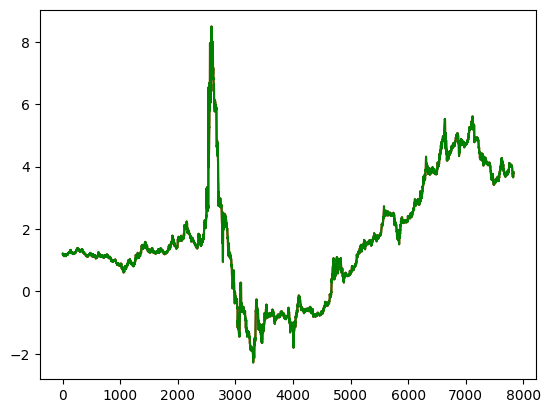

In [ ]:
plt.plot(test_score_df['USD'], 'r')
plt.plot(test_df['USD'], 'g')

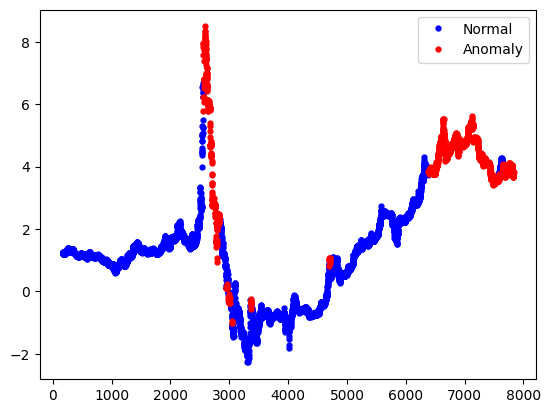

In [ ]:
true_points = test_score_df[test_score_df['anomaly'] == True]
false_points = test_score_df[test_score_df['anomaly'] == False]

plt.plot(false_points['USD'], 'bo', label='Normal', markersize=3.5)
plt.plot(true_points['USD'],  'ro', label='Anomaly', markersize=3.5)
plt.legend()

Вариант 3

In [ ]:
model = Sequential()
model.add(LSTM(
    units=64,
    input_shape=(trainX.shape[1], trainX.shape[2]),
    activation = 'tanh',
    recurrent_activation = 'sigmoid'
))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=trainX.shape[1]))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(
  TimeDistributed(Dense(units=trainX.shape[2]))
)
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    trainX, trainY,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/5
329/329 [==============================] - 85s 245ms/step - loss: 0.1493 - val_loss: 0.1647
Epoch 2/5
329/329 [==============================] - 78s 238ms/step - loss: 0.1756 - val_loss: 0.1605
Epoch 3/5
329/329 [==============================] - 90s 274ms/step - loss: 0.1720 - val_loss: 0.1366
Epoch 4/5
329/329 [==============================] - 79s 240ms/step - loss: 0.1575 - val_loss: 0.1168
Epoch 5/5
329/329 [==============================] - 78s 237ms/step - loss: 0.1480 - val_loss: 0.1093


730/730 [==============================] - 111s 151ms/step


(array([2330., 2038., 2311., 1798., 1213.,  640.,  512.,  397.,  841.,
         698.,  600.,  605.,  784.,  774.,  827.,  929.,  385.,  279.,
         462., 1168.,  650.,  508.,  401.,  276.,  290.,  399.,  238.,
         556.,  219.,  202.]),
 array([0.03498144, 0.10708516, 0.17918887, 0.25129259, 0.3233963 ,
        0.39550002, 0.46760373, 0.53970745, 0.61181117, 0.68391488,
        0.7560186 , 0.82812231, 0.90022603, 0.97232975, 1.04443346,
        1.11653718, 1.18864089, 1.26074461, 1.33284832, 1.40495204,
        1.47705576, 1.54915947, 1.62126319, 1.6933669 , 1.76547062,
        1.83757433, 1.90967805, 1.98178177, 2.05388548, 2.1259892 ,
        2.19809291]),
 <BarContainer object of 30 artists>)

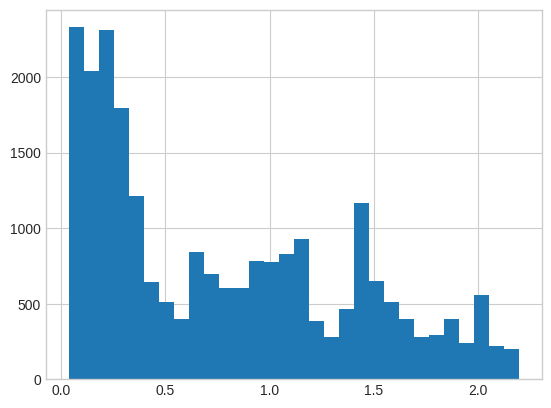

In [ ]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1) # MAE
plt.hist(trainMAE, bins=30)

240/240 [==============================] - 43s 180ms/step


(array([ 452.,  754.,  540.,  505.,  457., 1156.,  419.,  488.,  271.,
         225.,  221.,  209.,   86.,   66.,   54.,   44.,   71.,  199.,
         361.,  125.,   84.,  180.,  371.,  109.,  106.,   15.,   18.,
          16.,   24.,   38.]),
 array([0.25385434, 0.45615479, 0.65845524, 0.86075568, 1.06305613,
        1.26535658, 1.46765702, 1.66995747, 1.87225792, 2.07455837,
        2.27685881, 2.47915926, 2.68145971, 2.88376015, 3.0860606 ,
        3.28836105, 3.4906615 , 3.69296194, 3.89526239, 4.09756284,
        4.29986328, 4.50216373, 4.70446418, 4.90676463, 5.10906507,
        5.31136552, 5.51366597, 5.71596641, 5.91826686, 6.12056731,
        6.32286775]),
 <BarContainer object of 30 artists>)

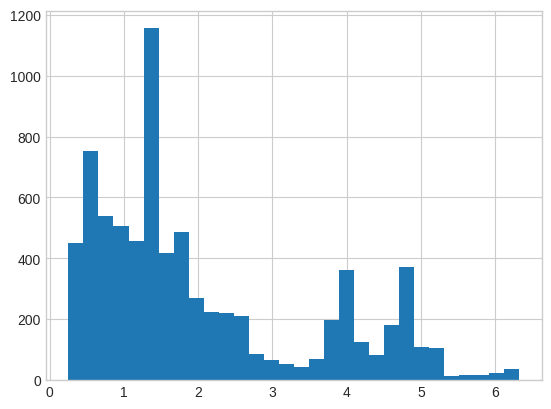

In [ ]:
max_trainMAE = 2.2  #Define threshold

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [ ]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test_df[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['USD'] = test_df[seq_size:]['USD']


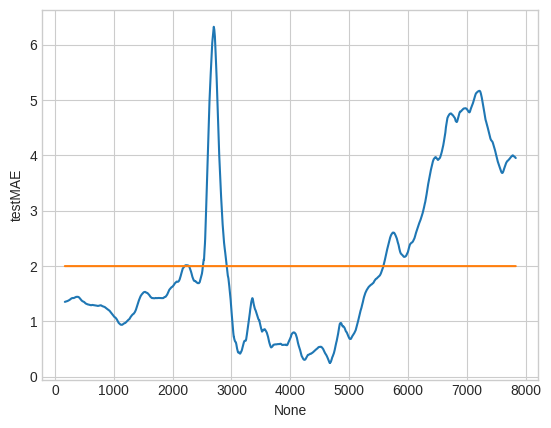

In [ ]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df.index, y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df.index, y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


## AER

https://arxiv.org/pdf/2212.13558v1.pdf

In [ ]:
model = Sequential()
model.add(LSTM(
    units=64,
    input_shape=(trainX.shape[1], trainX.shape[2]),
    activation = 'tanh',
  # recurrent_activation = 'sigmoid'
))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=trainX.shape[1] + 2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(
  TimeDistributed(Dense(units=trainX.shape[2]))
)
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
    trainX, trainY,
    epochs = 10,
    batch_size = 32,
    validation_split = 0.1,
    shuffle=False
)

Epoch 1/10
657/657 [==============================] - 116s 170ms/step - loss: 0.1178 - val_loss: 0.0799
Epoch 2/10
657/657 [==============================] - 113s 173ms/step - loss: 0.1136 - val_loss: 0.0813
Epoch 3/10
657/657 [==============================] - 111s 168ms/step - loss: 0.1224 - val_loss: 0.0844
Epoch 4/10
657/657 [==============================] - 111s 169ms/step - loss: 0.1211 - val_loss: 0.0923
Epoch 5/10
657/657 [==============================] - 112s 171ms/step - loss: 0.1038 - val_loss: 0.0806
Epoch 6/10
657/657 [==============================] - 111s 169ms/step - loss: 0.1140 - val_loss: 0.0840
Epoch 7/10
657/657 [==============================] - 110s 168ms/step - loss: 0.1171 - val_loss: 0.1394
Epoch 8/10
657/657 [==============================] - 111s 169ms/step - loss: 0.1191 - val_loss: 0.1410
Epoch 9/10
657/657 [==============================] - 110s 168ms/step - loss: 0.1235 - val_loss: 0.1566
Epoch 10/10
657/657 [==============================] - 108s 164m

In [ ]:
X_train_pred = model.predict(trainX)
train_mae_loss = np.mean(np.abs(X_train_pred[:, 1:-1, :] - trainX), axis=1)

730/730 [==============================] - 35s 47ms/step


(array([1573., 3921., 3599., 3193., 2082., 1511., 1096.,  897.,  884.,
         658.,  635.,  489.,  388.,  454.,  393.,  429.,  256.,  191.,
         132.,  151.,   94.,   78.,   64.,   66.,   41.,   17.,   13.,
          11.,    7.,    7.]),
 array([0.02233389, 0.05725109, 0.09216829, 0.12708549, 0.16200269,
        0.19691989, 0.23183709, 0.26675429, 0.30167148, 0.33658868,
        0.37150588, 0.40642308, 0.44134028, 0.47625748, 0.51117468,
        0.54609188, 0.58100908, 0.61592628, 0.65084348, 0.68576068,
        0.72067788, 0.75559508, 0.79051227, 0.82542947, 0.86034667,
        0.89526387, 0.93018107, 0.96509827, 1.00001547, 1.03493267,
        1.06984987]),
 <BarContainer object of 30 artists>)

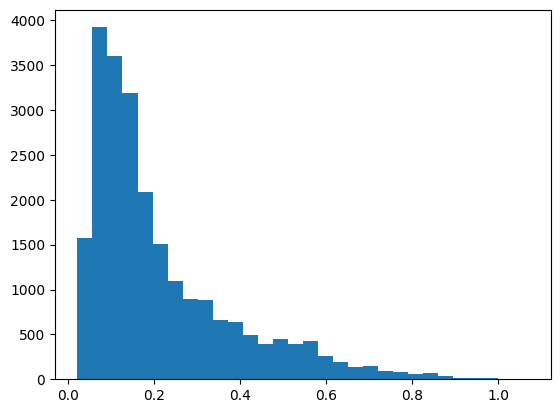

In [ ]:
plt.hist(train_mae_loss, bins=30)

In [ ]:
THRESHOLD = 0.9
X_test_pred = model.predict(testX)
test_mae_loss = np.mean(np.abs(X_test_pred[:, 1:-1, :] - testX), axis=1)

240/240 [==============================] - 12s 50ms/step


In [ ]:
np.mean(test_mae_loss)

0.8722642013622101

In [ ]:
test_score_df = pd.DataFrame(index=test_df[seq_size:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['USD'] = test_df[seq_size:].USD

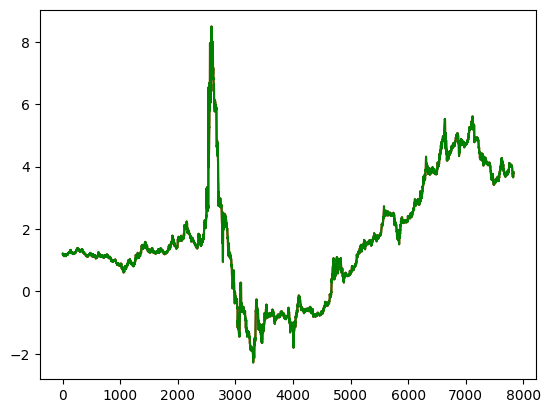

In [ ]:
plt.plot(test_score_df['USD'], 'r')
plt.plot(test_df['USD'], 'g')

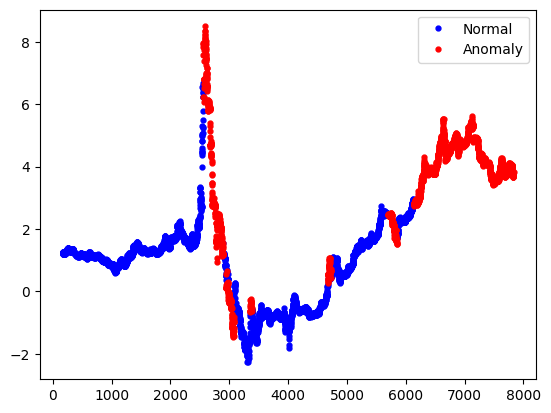

In [ ]:
true_points = test_score_df[test_score_df['anomaly'] == True]
false_points = test_score_df[test_score_df['anomaly'] == False]

plt.plot(false_points['USD'], 'bo', label='Normal', markersize=3.5)
plt.plot(true_points['USD'],  'ro', label='Anomaly', markersize=3.5)
plt.legend()